# Mode Seeking Behavior of Reverse KL-Optimization

The behavior of KL optimization shapes the way we design probabilistic models. It's machine learning "common knowledge" that minimizing reverse KL divergence leads to mode-seeking behavior. In this notebook, we empirically evaluate this claim, showing that it can be an oversimplification.

## Background: Reverse vs. Forward KL

Recall that the KL divergence between two distributions $p(\mathbf{x})$ and $q(\mathbf{x})$ is defined by

$$
    \text{KL}(p(\mathbf{x}) || q(\mathbf{x})) = \mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})} \left[\log\left(\frac{p(\mathbf{x})}{q(\mathbf{x})}\right)\right] = \int p(\mathbf{x}) \log \left(\frac{p(\mathbf{x})}{q(\mathbf{x})}\right) d\mathbf{x}.
$$

When approximating a fixed distribution $p(\mathbf{x})$ with a variational distribution $q_\theta(\mathbf{x})$ via KL minimization, we intuitively expect different behaviors depending on the "direction" of the KL loss:

- **Forward KL:** Optimizing for $\text{argmin}_\theta \text{KL}(p(\mathbf{x}) || q_\theta(\mathbf{x}))$ forces $q_\theta(\mathbf{x})$ to include all areas for which $p(\mathbf{x})$ assigns non-zero mass, resulting in mode covering behavior.

- **Reverse KL:** Optimizing for $\text{argmin}_\theta \text{KL}(q_\theta(\mathbf{x}) || p(\mathbf{x}))$ forces $q_\theta(\mathbf{x})$ to exclude all the areas for which $p(\mathbf{x})$ is zero, resulting in mode seeking behavior with $q_\theta(\mathbf{x})$ assigning mass to few parts of the space, near $p(\mathbf{x})$'s modes.

For a deeper overview, see [Murphy's "Probabilistic Machine Learning: An Introduction"](https://probml.github.io/pml-book/book1.html) or [our recent paper](https://www.arxiv.org/pdf/2408.05496).

In the following, we take a closer look at the mode-seeking behavior of reverse KL minimization. We empirically evaluate it in the case of approximating a Gaussian mixture with a single variational Gaussian. We demonstrate that mode seeking behavior does arise, but only when the modes of the target distribution are sufficiently far apart.

In [1]:
# Install dependencies
%pip install -U jax optax matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 MB 11.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.31
    Uninstalling jaxlib-0.4.31:
      Successfully uninstalled jaxlib-0.4.31
  Attempting uninstall: jax
    Found existing installation: jax 0.4.31
    Uninstalling jax-0.4.31:
      Successfully uninstalled jax-0.4.31
Note: you may need to restart the kernel to use updated packages.


In [2]:
import jax
import jax.numpy as jnp
import optax
import tqdm
import matplotlib.pyplot as plt

from functools import partial
from typing import Tuple, Mapping

The target distribution is given by a mixture of two Gaussians 
$$
p_\alpha(\mathbf{x}) = \frac{1}{2} \mathcal{N}(\mathbf{x}; \mathbf{0}, I) + \frac{1}{2} \mathcal{N}(\mathbf{x}; \mathbf{u}_\alpha, I), 
$$
where $\mathbf{u}_\alpha = \alpha \cdot \mathbf{e}_1 \in \mathbb{R}^d$ and $\alpha \in \mathbb{R}$ quantifies the discrepancy between the two mixture components. The approximating variational distribution is given by 
$$
q_\theta(\mathbf{x}) = q_{\boldsymbol{\mu}, \boldsymbol{\Sigma}}(\mathbf{x})  = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}), 
$$
where $\boldsymbol{\mu} \in \mathbb{R}^d$ is the parametric mean and $\boldsymbol{\Sigma} = \text{diag}(\sigma_1^2, \ldots, \sigma_d^2)$ is the parametric diagonal covariance matrix.

In [3]:
@jax.jit
def diagonal_gaussian_logpdf(
    xs: jax.Array, mean: jax.Array, cov_diag: jax.Array
) -> jax.Array:
    dim = mean.shape[0]

    return -0.5 * (
        dim * jnp.log(2.0 * jnp.pi)
        + jnp.sum(jnp.log(cov_diag))
        + jnp.sum(((xs - mean) ** 2) / cov_diag, axis=-1)
    )


@jax.jit
def diagonal_gaussian_mixture_logpdf(
    xs: jax.Array,
    mean1: jax.Array,
    cov_diag1: jax.Array,
    mean2: jax.Array,
    cov_diag2: jax.Array,
) -> jax.Array:
    return -jnp.log(2.0) + jnp.logaddexp(
        diagonal_gaussian_logpdf(xs, mean1, cov_diag1),
        diagonal_gaussian_logpdf(xs, mean2, cov_diag2),
    )

We evalutate the reverse KL divergence $\text{KL}(q_\theta(\mathbf{x}) || p(\mathbf{x}))$ using Monte Carlo estimation, sampling $N$ points $\mathbf{x}_1, \dots, \mathbf{x}_N \sim q_\theta(\mathbf{x})$ i.i.d. and estimating the expectation by the sample average $\frac{1}{N}\sum_{i=1}^N \log \left(\frac{q_\theta(\mathbf{x}_i)}{p(\mathbf{x}_i)}\right)$.

In [4]:
@partial(jax.jit, static_argnums=3)
def reverse_kl_estimate(
    params: Mapping[str, jax.Array],
    discrepancy: float,
    component_std: float,
    number_of_samples: int,
    rng: jax.random.PRNGKey,
) -> float:
    mean = params["mean"]
    logcov_diag = params["logcov_diag"]

    assert (
        mean.shape == logcov_diag.shape == (mean.shape[0],)
    ), "Mean and log(diag(cov)) must be 1D arrays of the same size"

    dim = mean.shape[0]

    # Sample from variational Gaussian
    samples = mean + jnp.exp(0.5 * logcov_diag) * jax.random.normal(
        rng, shape=(number_of_samples, dim)
    )

    # First standard basis vector scaled by discrepancy
    u = discrepancy * jnp.eye(dim)[0]

    # Compute the reverse KL, estimating the expectation via Monte Carlo
    return jnp.mean(
        diagonal_gaussian_logpdf(
            xs=samples,
            mean=mean,
            cov_diag=jnp.exp(logcov_diag),
        )
        - diagonal_gaussian_mixture_logpdf(
            xs=samples,
            mean1=jnp.zeros(dim),
            cov_diag1=component_std**2 * jnp.ones(dim),
            mean2=u,
            cov_diag2=component_std**2 * jnp.ones(dim),
        )
    )

We optimize the reverse KL divergence $\text{KL}(q_{\boldsymbol{\mu}, \boldsymbol{\Sigma}}(\mathbf{x}) || p(\mathbf{x}))$ using gradient descent. To further encourage mode seeking, we start the optimization from $\boldsymbol{\mu} = \mathbf{0}, \boldsymbol{\Sigma} = \text{diag}(1, \dots, 1)$ (which is the first component of the mixture). We evaluate the behavior of the optimization process via the normalized mean deviation of the variational Gaussian's mean from the mixture component it is initialized at ($\frac{1}{\alpha}\lVert \boldsymbol{\mu} \rVert_2$). Mode seeking behavior is indicated by mean deviation close to $0$, the other extreme, which we call "mean seeking" behavior,  is indicated by mean deviation close to $\frac{1}{2}$.


In [5]:
def kl_optimize(
    discrepancy: float,
    component_std: float,
    dim: int,
    rng: jax.random.PRNGKey,
    number_of_steps: int = 2000,
    number_of_samples: int = 2000,
    learning_rate: float = 1e-2,
) -> Tuple[jax.Array, float, float]:
    # Start optimization from a mode of the mixture to encourage mode seeking behavior
    params = {"mean": jnp.zeros(dim), "logcov_diag": jnp.zeros(dim)}

    # Use the Adam optimizer
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(params)

    # Optimize reverse KL
    for _ in range(number_of_steps):
        rng, subrng = jax.random.split(rng)

        # Compute loss and gradient
        loss, grad = jax.value_and_grad(reverse_kl_estimate)(
            params, discrepancy, component_std, number_of_samples, subrng
        )

        # Update parameters
        updates, opt_state = optimizer.update(grad, opt_state)

        # Apply updates
        params = optax.apply_updates(params, updates)

    return params["mean"], jnp.mean(jnp.exp(params["logcov_diag"])), loss

In [6]:
def run_experiments(
    discrepancies: jax.Array,
    component_std: float,
    dim: int,
    number_of_steps: int = 1000,
    number_of_samples: int = 1000,
    rng: jax.random.PRNGKey = jax.random.PRNGKey(42),
) -> Tuple[jax.Array, jax.Array, jax.Array]:
    mean_deviations = []
    avg_vars = []
    kl_values = []

    for discrepancy in (pbar := tqdm.tqdm(discrepancies)):
        rng, subrng = jax.random.split(rng)

        # Optimize KL divergence for current component discrepancy
        mean, avg_var, kl_value = kl_optimize(
            discrepancy, component_std, dim, subrng, number_of_steps, number_of_samples
        )

        # Compute solution's normalized mean deviation
        mean_deviation = jnp.sqrt(jnp.sum(mean**2)) / discrepancy

        # Update progress bar
        pbar.set_description(
            f"Discrepancy: {discrepancy:.2f}, mean deviation: {mean_deviation:.2f}, avg var: {avg_var:.2f}, opt KL: {kl_value:.2f}"
        )

        # Store results
        mean_deviations.append(mean_deviation)
        avg_vars.append(avg_var)
        kl_values.append(kl_value)

    return jnp.array(mean_deviations), jnp.array(avg_vars), jnp.array(kl_values)

In [7]:
def plot_results(
    discrepancies: jax.Array,
    mean_deviations: jax.Array,
    det_covs: jax.Array,
    kl_values: jax.Array,
    title: str,
):
    _, axes = plt.subplots(1, 3, figsize=(9, 3))

    for ax, data, plot_title, color in zip(
        axes,
        [mean_deviations, det_covs, kl_values],
        ["$\\alpha^{-1} \\| \\mu \\| _2$", "avg var", "optimal KL"],
        ["red", "green", "blue"],
    ):
        ax.plot(discrepancies, data, color=color, linewidth=2)
        ax.set_xlabel("component discrepancy ($\\alpha$)", fontsize=12)
        ax.set_ylabel(plot_title, fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    plt.suptitle(title, fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

We plot the normalized mean deviation, average variance per entry, and optimal KL value for a 2D experiment as a function of the discrepancy $\alpha \in [0, 10]$. We see a clear threshold for mode seeking behavior at $\alpha \approx 5$.


Discrepancy: 10.00, mean deviation: 0.00, avg var: 1.00, opt KL: 0.69: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


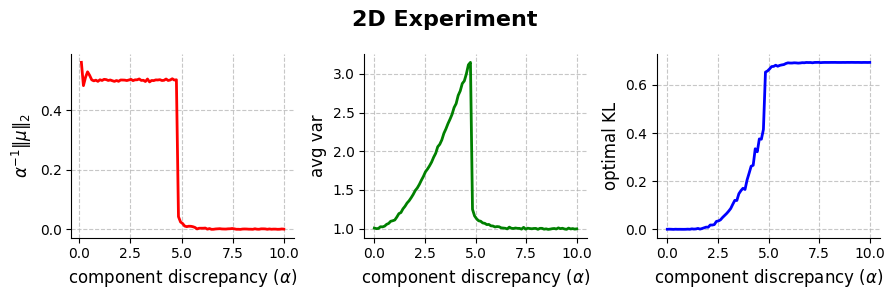

In [8]:
discrepancies = jnp.linspace(0.0, 10.0, 100)

mean_deviations, avg_vars, kl_values = run_experiments(
    discrepancies=discrepancies,
    component_std=1.0,
    dim=2,
    number_of_steps=1000,
    number_of_samples=5000,
)

plot_results(discrepancies, mean_deviations, avg_vars, kl_values, "2D Experiment")

Note that: 
1. The threshold for mode seeking behavior scales with the standard deviation of the mixture components:

Discrepancy: 10.00, mean deviation: 0.00, avg var: 0.25, opt KL: 0.69: 100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


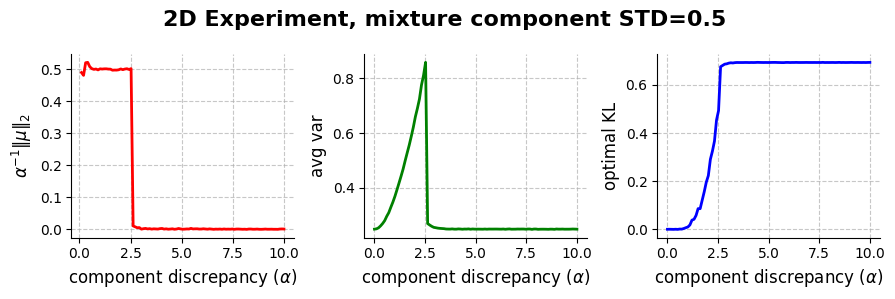

In [9]:
mean_deviations, avg_vars, kl_values = run_experiments(
    discrepancies=discrepancies,
    component_std=0.5,
    dim=2,
    number_of_steps=1000,
    number_of_samples=5000,
)

plot_results(
    discrepancies,
    mean_deviations,
    avg_vars,
    kl_values,
    "2D Experiment, mixture component STD=0.5",
)

2. The threshold for mode seeking behavior is independent of the dimensionality of the problem:

Discrepancy: 10.00, mean deviation: 0.00, avg var: 0.25, opt KL: 0.69: 100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


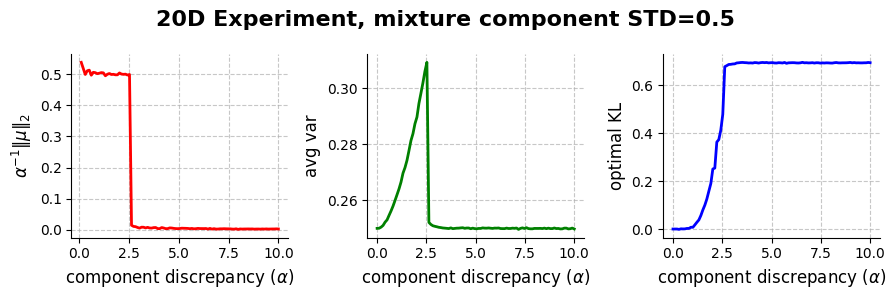

In [10]:
mean_deviations, avg_vars, kl_values = run_experiments(
    discrepancies=discrepancies,
    component_std=0.5,
    dim=20,
    number_of_steps=1000,
    number_of_samples=5000,
)

plot_results(
    discrepancies,
    mean_deviations,
    avg_vars,
    kl_values,
    "20D Experiment, mixture component STD=0.5",
)

The following is an animation of the optimizer and the mixture distributions for a 1D experiment with $\alpha \in [0, 6]$.

In [11]:
from matplotlib import animation
from scipy.stats import norm

def animate_optimizer(means, variances, discrepancies):
    fig, ax = plt.subplots(figsize=(6, 3))
    x = jnp.linspace(-10, 10, 1000)

    (gaussian,) = ax.plot([], [], linewidth=4, color="#67cead", label="$q_{\\mu, \\sigma}(x)$")
    (mixture,) = ax.plot(
        [], [], linewidth=4, color="#071b51", label="$p_\\alpha(x)$"
    )

    ax.set_xlim(-3, 9)
    ax.set_ylim(-0.0, 0.42)
    # ax.set_xlabel("x", fontsize=16)
    ax.set_ylabel("probability density", fontsize=16)
    ax.grid(True)
    ax.legend(fontsize=14)

    def init():
        gaussian.set_data([], [])
        mixture.set_data([], [])
        return gaussian, mixture

    def animate(i):
        y = norm.pdf(x, means[i] * discrepancies[i], jnp.sqrt(variances[i]))
        gaussian.set_data(x, y)

        # Create Gaussian mixture
        mixture_y = 0.5 * norm.pdf(x, 0, 1) + 0.5 * norm.pdf(x, discrepancies[i], 1)
        mixture.set_data(x, mixture_y)

        ax.set_title(
            f"$\\alpha$ = {discrepancies[i]:.2f}, $\\mu$ = {means[i] * discrepancies[i]:.2f}, $\\sigma^2$ = {variances[i]:.2f}",
            fontsize=16,
        )
        return gaussian, mixture

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=discrepancies.shape[0],
        interval=100,
        blit=True,
    )

    anim.save("optim.gif")

Discrepancy: 6.00, mean deviation: 0.00, avg var: 1.04, opt KL: 0.69: 100%|██████████| 70/70 [00:19<00:00,  3.62it/s] 
MovieWriter ffmpeg unavailable; using Pillow instead.


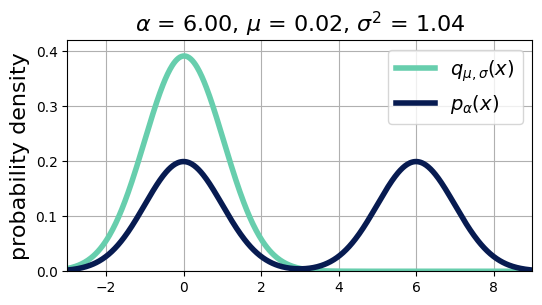

In [12]:
discrepancies = jnp.linspace(0.0, 6.0, 70)
mean_deviations, avg_vars, kl_values = run_experiments(
    discrepancies=discrepancies,
    component_std=1,
    dim=1,
    number_of_steps=200,
    number_of_samples=5000,
)

animate_optimizer(mean_deviations, avg_vars, discrepancies)